In [1]:
%matplotlib widget
import numpy as np
import os
import matplotlib.pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
root_path = "semantic_3d_pointcloud/"

point = np.load(os.path.join(root_path, "point.npy"))
point = point*10000/255.
color = np.load(os.path.join(root_path, "color0255.npy"))
color = color/255.
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point)
pcd.colors = o3d.utility.Vector3dVector(color)

points = np.asarray(pcd.points)
pcd = pcd.select_by_index(np.where(points[:, 1] < 0)[0])
points = np.asarray(pcd.points)
pcd = pcd.select_by_index(np.where(points[:, 1] > -1)[0])
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)
int_colors = colors * 255
# colors *= 255
# plt.scatter(-points[:, 2], -points[:, 0], s=1, c=colors, alpha=0.5)

In [3]:
print("select target categories (refrigerator, rack, cushion, lamp, and cooktop")
color_dict = {
    "refrigerator":[255, 0, 0],
    "rack": [0, 255, 133],
    "cushion": [255, 9, 92],
    "lamp": [160, 150, 20],
    "cooktop": [7, 255, 224]
    }

offset = {
    "refrigerator":[-0.25, 0, 0],
    "rack": [0, 0, -0.3],
    "cushion": [0, 0, 0],
    "lamp": [0, 0, 0.5],
    "cooktop": [0.6, 0, 0]
}
target = input()
target_list = []
for i in range(len(int_colors)):
    if np.array_equal(int_colors[i], color_dict[target]):
        target_list.append(i)

target_point = np.mean(points[target_list], axis=0)
target_point += offset[target]

select target categories (refrigerator, rack, cushion, lamp, and cooktop


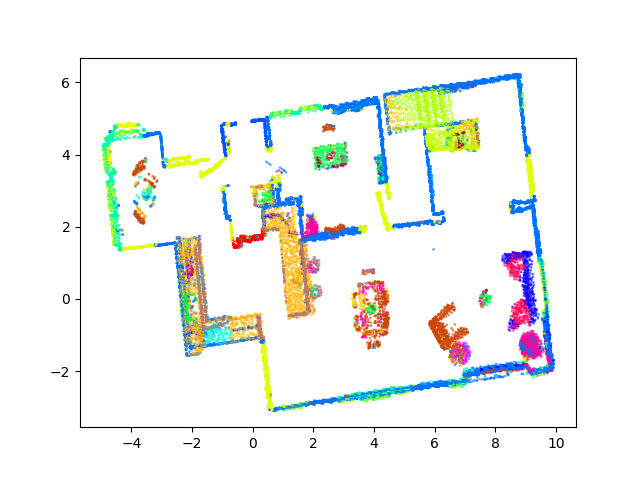

7.424791916877162 2.0754221533774455


In [4]:
fig = plt.figure()
map = fig.add_subplot()
map.scatter(points[:, 2], points[:, 0], s=1, c=colors, alpha=0.5)
coords = []

def onclick(event):
    global coords
    print(event.xdata, event.ydata)
    coords.append((event.xdata, event.ydata))
    fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

[(7.424791916877162, 2.0754221533774455)]


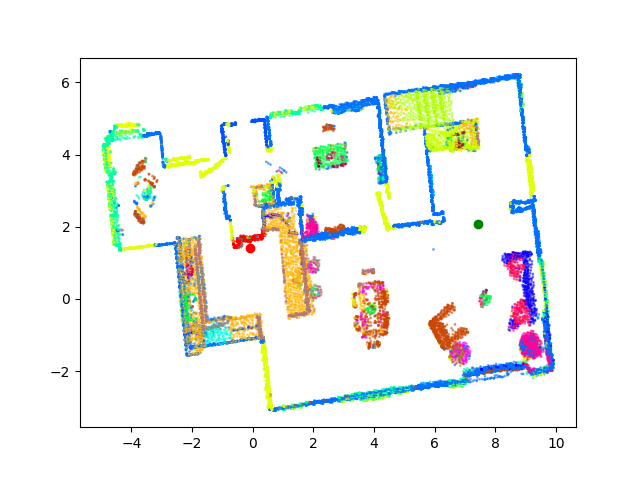

In [5]:
print(coords)
plt.plot(coords[0][0], coords[0][1], "og")
plt.plot(target_point[2], target_point[0], "or")
plt.show()

In [6]:
import random
import math
import copy
import time

In [11]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.cost = 0.0
        self.parent = None


class RRT:
    def __init__(self, obstacle_list, obstacle_color, x_rand_area, y_rand_area, expand_dis=2.0, goal_sample_rate=10, max_iter=200, radius=0.1):
        self.start = None
        self.end = None
        self.x_min_rand = x_rand_area[0]
        self.x_max_rand = x_rand_area[1]
        self.y_max_rand = y_rand_area[1]
        self.y_min_rand = y_rand_area[0]
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.obstacle_color = obstacle_color
        self.node_list = None
        self.expand_dis = expand_dis
        self.radius = radius


    def rrt_planning(self, start, goal, animation=True):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.node_list = [self.start]
        path = None

        for i in range(self.max_iter):
            print(f"==================\nstep: {i + 1}\nNodes in RRT Tree: {len(self.node_list)}\n==================\n")
            # random sample
            rnd = self.sample()

            # find the nearest node to the sample point in node tree
            nearest_index = self.get_nearest_node_index(self.node_list, rnd)
            nearest_node = self.node_list[nearest_index]

            # get next node
            theta = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)
            new_node = self.get_new_node(theta, nearest_index, nearest_node)

            # check collision
            collision = self.check_collision(new_node.x, new_node.y, nearest_node.x, nearest_node.y)
            if not collision:
                self.node_list.append(new_node)

                if animation:
                    time.sleep(1)
                    self.draw_graph(new_node, path)

                #  check if new node is close to goal
                if self.is_near_goal(new_node):
                    if not self.check_collision(new_node.x , new_node.y, self.goal.x, self.goal.y):
                        last_index = len(self.node_list) - 1
                        path = self.get_final_course(last_index)


                        if animation:
                            self.draw_graph(new_node, path)
                        return path
                        

    def sample(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = [random.uniform(self.x_min_rand, self.x_max_rand),
                   random.uniform(self.y_min_rand, self.y_max_rand)]
        else:
            rnd = [self.goal.x, self.goal.y]

        return rnd


    def get_new_node(self, theta, nearest_index, nearest_node):
        new_node = copy.deepcopy(nearest_node)
        new_node.x += self.expand_dis * math.cos(theta)
        new_node.y += self.expand_dis * math.sin(theta)

        new_node.cost += self.expand_dis
        new_node.parent = nearest_index
        
        return new_node


    def check_collision(self, x1, y1, x2, y2):
        for (oy, _, ox) in self.obstacle_list:
            dd = self.distance_square_point_to_segment(
                np.array([x1, y1]),
                np.array([x2, y2]),
                np.array([ox, oy])
            )

            if dd <= self.radius ** 2:
                return True
        
        return False


    def is_near_goal(self, node):
        d = self.line_cost(node, self.goal)
        if d < self.radius:
            return True
        return False


    def get_final_course(self, last_index):
        path = [[self.goal.x, self.goal.y]]
        while self.node_list[last_index].parent is not None:
            node = self.node_list[last_index]
            path.append([node.x, node.y])
            last_index = node.parent
        
        path.append([self.start.x, self.start.y])
        return path


    def draw_graph(self, rnd=None, path=None):
        plt.clf()

        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")

        for node in self.node_list:
            if node.parent is not None:
                if node.x or node.y is not None:
                    plt.plot([node.x, self.node_list[node.parent].x],
                             [node.y, self.node_list[node.parent].y],
                             '-g')

        plt.plot(self.start.x, self.start.y, "og")
        plt.plot(self.goal.x, self.goal.y, "or")


        plt.scatter(self.obstacle_list[:, 2], self.obstacle_list[:, 0], s=1, c=self.obstacle_color, alpha=0.5)

        if path is not None:
            plt.plot([x for (x, y) in path], [y for (x, y) in path], "-r")

        plt.pause(0.01)


    @staticmethod
    def get_nearest_node_index(node_list, rnd):
        dist = [(node.x-rnd[0])**2 + (node.y - rnd[1])**2 for node in node_list]
        min_index = dist.index(min(dist))
        return min_index


    @staticmethod
    def distance_square_point_to_segment(v, w, p):
        if np.array_equal(v, w):
            return (p - v).dot(p - v)
        
        l2 = (w -v).dot(w - v)
        t = max(0, min(1, (p - v).dot(w - v) / l2))
        projection = v + t * (w - v)
        return (p - projection).dot(p - projection)
    

    @staticmethod
    def line_cost(node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)

step: 1
Nodes in RRT Tree: 1

step: 2
Nodes in RRT Tree: 1



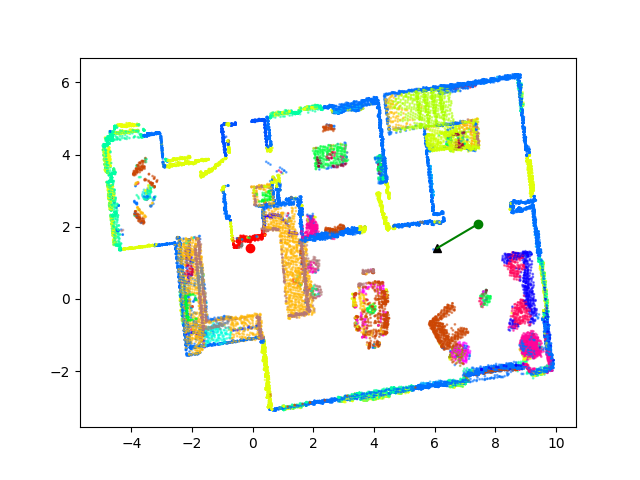

step: 3
Nodes in RRT Tree: 2

step: 4
Nodes in RRT Tree: 2

step: 5
Nodes in RRT Tree: 2

step: 6
Nodes in RRT Tree: 2

step: 7
Nodes in RRT Tree: 2



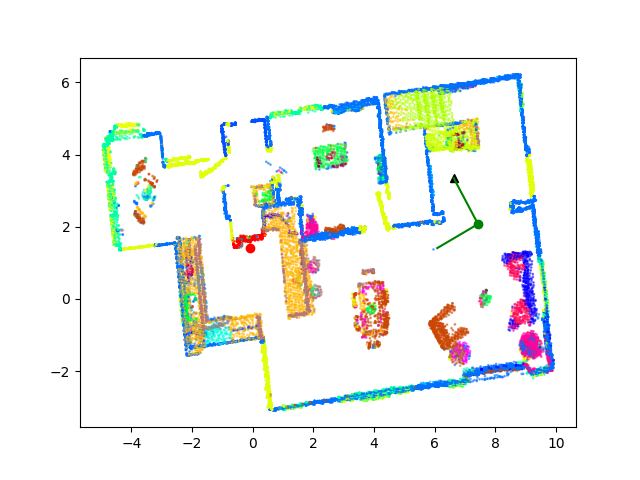

step: 8
Nodes in RRT Tree: 3

step: 9
Nodes in RRT Tree: 3

step: 10
Nodes in RRT Tree: 3

step: 11
Nodes in RRT Tree: 3

step: 12
Nodes in RRT Tree: 3



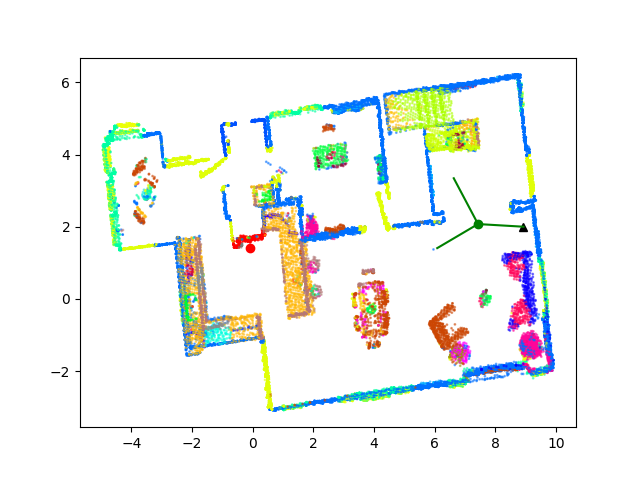

step: 13
Nodes in RRT Tree: 4

step: 14
Nodes in RRT Tree: 4

step: 15
Nodes in RRT Tree: 4

step: 16
Nodes in RRT Tree: 4

step: 17
Nodes in RRT Tree: 4

step: 18
Nodes in RRT Tree: 4

step: 19
Nodes in RRT Tree: 4

step: 20
Nodes in RRT Tree: 4

step: 21
Nodes in RRT Tree: 4

step: 22
Nodes in RRT Tree: 4

step: 23
Nodes in RRT Tree: 4

step: 24
Nodes in RRT Tree: 4

step: 25
Nodes in RRT Tree: 4



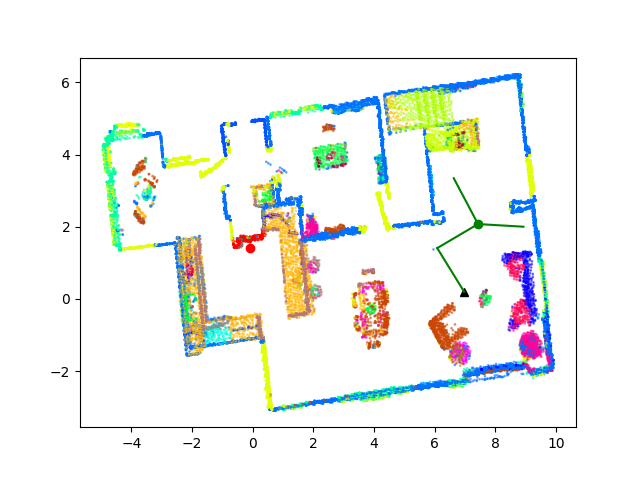

step: 26
Nodes in RRT Tree: 5

step: 27
Nodes in RRT Tree: 5



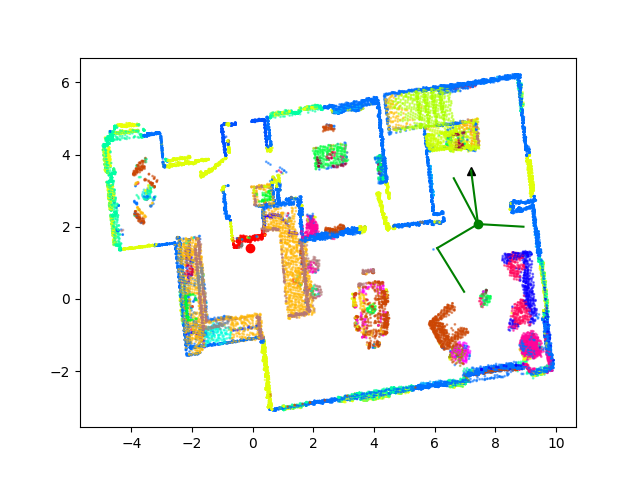

step: 28
Nodes in RRT Tree: 6

step: 29
Nodes in RRT Tree: 6

step: 30
Nodes in RRT Tree: 6

step: 31
Nodes in RRT Tree: 6

step: 32
Nodes in RRT Tree: 6

step: 33
Nodes in RRT Tree: 6

step: 34
Nodes in RRT Tree: 6

step: 35
Nodes in RRT Tree: 6

step: 36
Nodes in RRT Tree: 6

step: 37
Nodes in RRT Tree: 6

step: 38
Nodes in RRT Tree: 6

step: 39
Nodes in RRT Tree: 6



KeyboardInterrupt: 

In [13]:
x_area = (-6, 10)
y_area = (-4, 6)

rrt = RRT(points, colors, x_area, y_area, expand_dis=1.5)
start = [coords[0][0], coords[0][1]]
goal = [target_point[2], target_point[0]]
path = rrt.rrt_planning(start=start, goal=goal, animation=True)
rrt.draw_graph()
plt.show()